<a href="https://www.kaggle.com/code/gustikresna/toyota-price-prediction-97-r2?scriptVersionId=90412966" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv


# **1. Introduction**
<div style="text-align:center"><img src="https://swall.teahub.io/photos/small/50-506052_wallpaper-toyota-supra-toyota-sportscar-white-rear-toyota.jpg" width="600">

Toyota is one of the largest car manufacturer in the world and currently hold the largest market share worldwide. It has wide range of model from MPV to sports car where the price range is also varied.

In this notebook, I have conducted EDA and built simple model to predict the price of Toyota used car in UK.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import metrics, cv, CatBoostRegressor
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

# **2. Import Dataset**

In [3]:
df = pd.read_csv("/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [4]:
df.head()

model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0   GT86  2016  16000       Manual    24089   Petrol  265  36.2         2.0
1   GT86  2017  15995       Manual    18615   Petrol  145  36.2         2.0
2   GT86  2015  13998       Manual    27469   Petrol  265  36.2         2.0
3   GT86  2017  18998       Manual    14736   Petrol  150  36.2         2.0
4   GT86  2017  17498       Manual    36284   Petrol  145  36.2         2.0

In [5]:
df['model'].unique()

array([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR',
       ' Prius', ' Avensis', ' Verso', ' Hilux', ' PROACE VERSO',
       ' Land Cruiser', ' Supra', ' Camry', ' Verso-S', ' IQ',
       ' Urban Cruiser'], dtype=object)

The text in each of the model name appears to have whitespace in the front

In [6]:
df['model'] = df['model'].str.strip()

# **3. EDA**

Before the EDA, i split the dataset into train and test set to prevent data leak.

In [7]:
y = df['price']
X = df.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4716 entries, 1072 to 1140
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4716 non-null   object 
 1   year          4716 non-null   int64  
 2   transmission  4716 non-null   object 
 3   mileage       4716 non-null   int64  
 4   fuelType      4716 non-null   object 
 5   tax           4716 non-null   int64  
 6   mpg           4716 non-null   float64
 7   engineSize    4716 non-null   float64
 8   price         4716 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 368.4+ KB


In [8]:
prof = ProfileReport(df_train)
prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## **3A. Price**

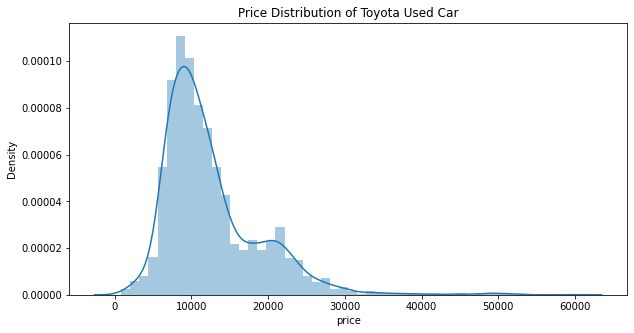

In [9]:
plt.figure(figsize=(10,5))
sns.distplot(df_train['price'])
plt.title('Price Distribution of Toyota Used Car')
plt.show()

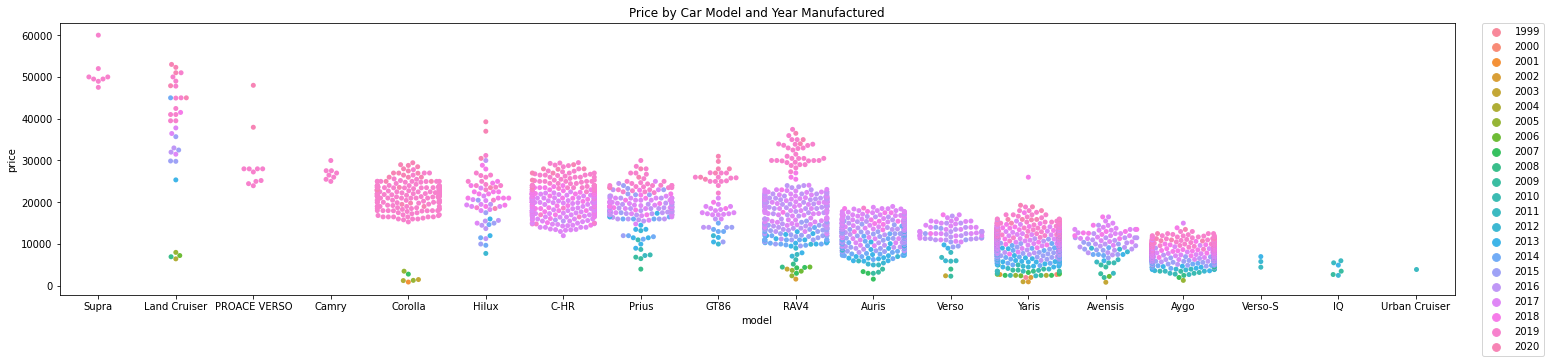

In [10]:
table= df_train.groupby(['model'],as_index=False)['price'].median().sort_values(by='price',ascending=False)

plt.figure(figsize=(25,5))
sns.swarmplot(x='model',y='price', data=df_train, order=table['model'].to_list(), hue='year')
plt.title('Price by Car Model and Year Manufactured')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

We could notice the distribution of price for each model and the year produced. In this dataset, the most expensive car is one of the Toyota famous sports car, Supra. Moreover, year seems to be a good predictor of the price since it could distinguish the price.

## **3B. Model**

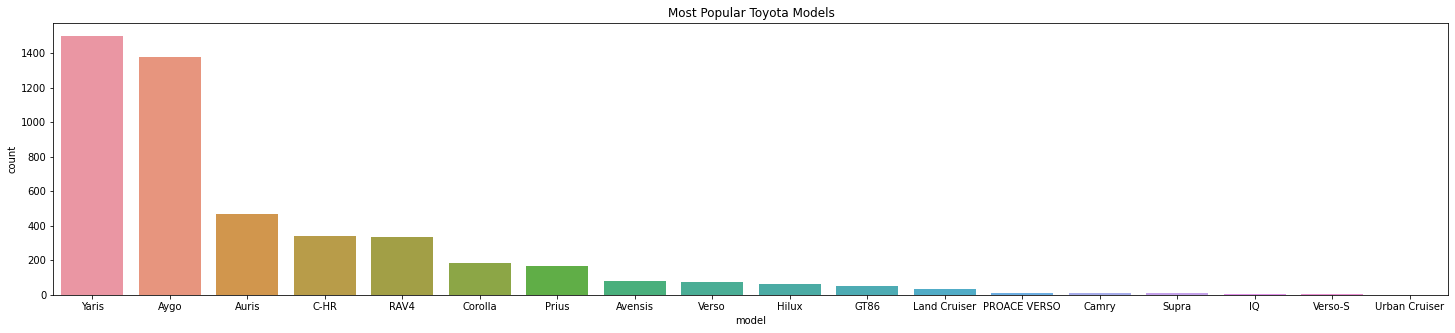

In [11]:
plt.figure(figsize=(25,5))
sns.countplot(x='model', data=df_train, order=df_train['model'].value_counts().index)
plt.title('Most Popular Toyota Models')
plt.show()

In the dataset, Yaris and Aygo are by far the most popular Toyota brand cars in the UK. Considering the price from the previous chart, the price of both models are positioned in the lower group.

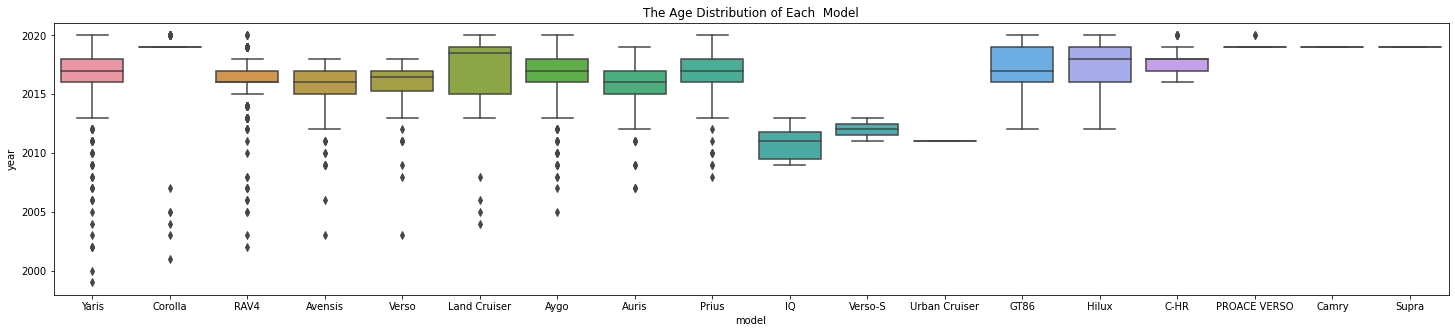

In [12]:
table_age = df_train.groupby('model', as_index=False)['year'].min().sort_values(by='year')

plt.figure(figsize=(25,5))
sns.boxplot(x='model', y='year',data=df_train, order=table_age['model'])
plt.title('The Age Distribution of Each  Model')
plt.show()

The chart shows that Yaris has wide-range of ages than the other model. Eventhough the price is relatively low, its old cars are still tradeable which means that the price does not affect the durability.

## **3C. Transmission**

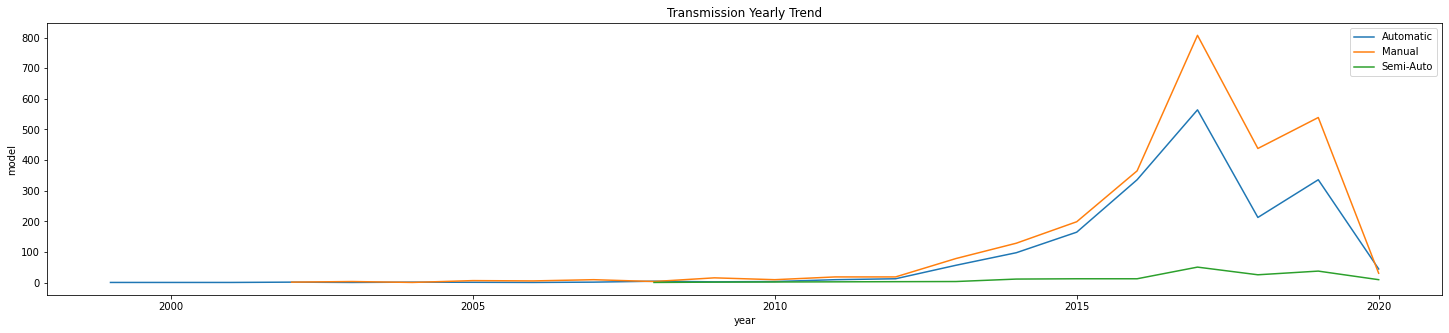

In [13]:
trans_year = df_train.copy().groupby(['transmission','year'],as_index=False).count()
trans_year_auto = trans_year[trans_year['transmission']=='Automatic']
trans_year_man = trans_year[trans_year['transmission']=='Manual']
trans_year_sem = trans_year[trans_year['transmission']=='Semi-Auto']

plt.figure(figsize=(25,5))
sns.lineplot(x='year',y='model',data=trans_year_auto, label='Automatic')
sns.lineplot(x='year',y='model',data=trans_year_man, label='Manual')
sns.lineplot(x='year',y='model',data=trans_year_sem, label='Semi-Auto')
plt.title('Transmission Yearly Trend')
plt.show()

The automatic and manual transmission appears to have similar annual trends with the manual dominated the UK used car market of Toyota brand.

## **3D. Mileage**

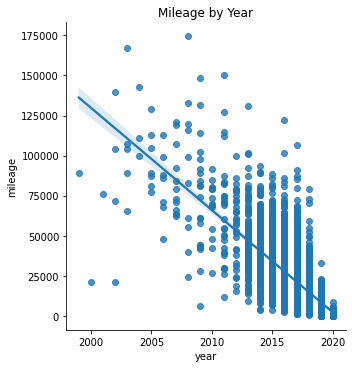

In [14]:
sns.lmplot(x='year',y='mileage',data=df_train)
plt.title('Mileage by Year')
plt.show()

Obviously, the older the car the higher the mileage is. However, the chart indicates that some old cars were used less frequent by the owners.

## **3E. Fuel Type**

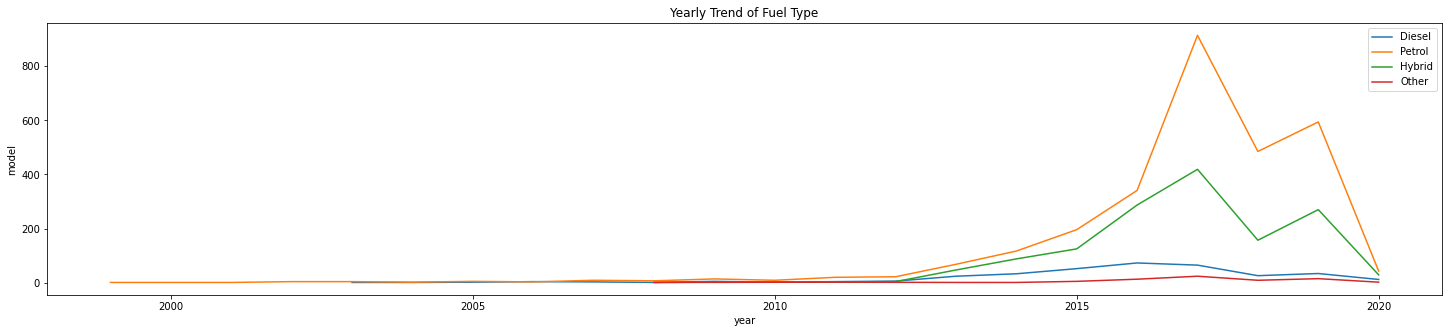

In [15]:
fuel_year = df_train.copy().groupby(['fuelType','year'],as_index=False).count()
fuel_year_diesel = fuel_year[fuel_year['fuelType']=='Diesel']
fuel_year_petrol = fuel_year[fuel_year['fuelType']=='Petrol']
fuel_year_hybrid = fuel_year[fuel_year['fuelType']=='Hybrid']
fuel_year_other = fuel_year[fuel_year['fuelType']=='Other']

plt.figure(figsize=(25,5))
sns.lineplot(x='year',y='model',data=fuel_year_diesel,label='Diesel')
sns.lineplot(x='year',y='model',data=fuel_year_petrol,label='Petrol')
sns.lineplot(x='year',y='model',data=fuel_year_hybrid,label='Hybrid')
sns.lineplot(x='year',y='model',data=fuel_year_other,label='Other')
plt.title('Yearly Trend of Fuel Type')
plt.show()

The trend of the fuel type of the cars seems to experience insignificant change where the petrol cars are always the most popular.

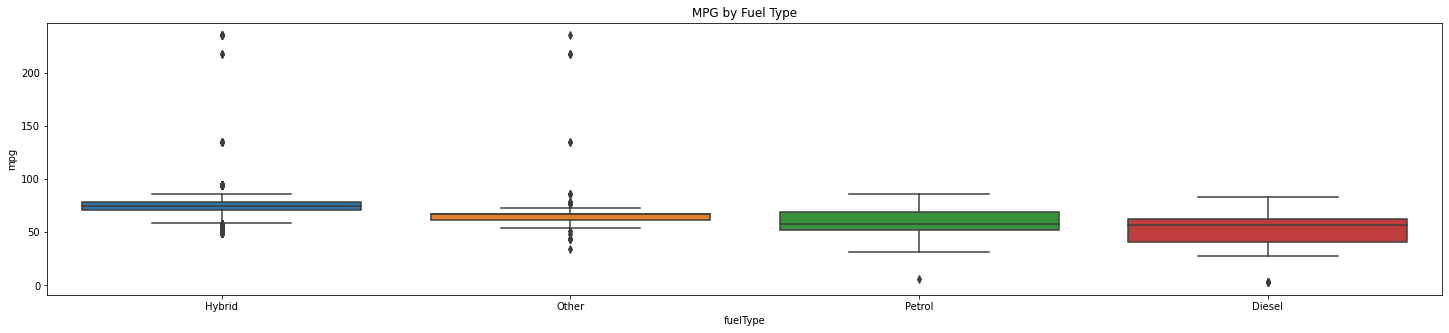

In [16]:
table_mpg = df_train.copy().groupby('fuelType',as_index=False)['mpg'].median().sort_values(by='mpg',ascending=False)
plt.figure(figsize=(25,5))
sns.boxplot(x='fuelType', y='mpg', data=df_train, order=table_mpg['fuelType'])
plt.title('MPG by Fuel Type')
plt.show()

Hybrid cars are clearly the most efficient, while the diesel cars are the opposite.

## **3F. Engine Size**

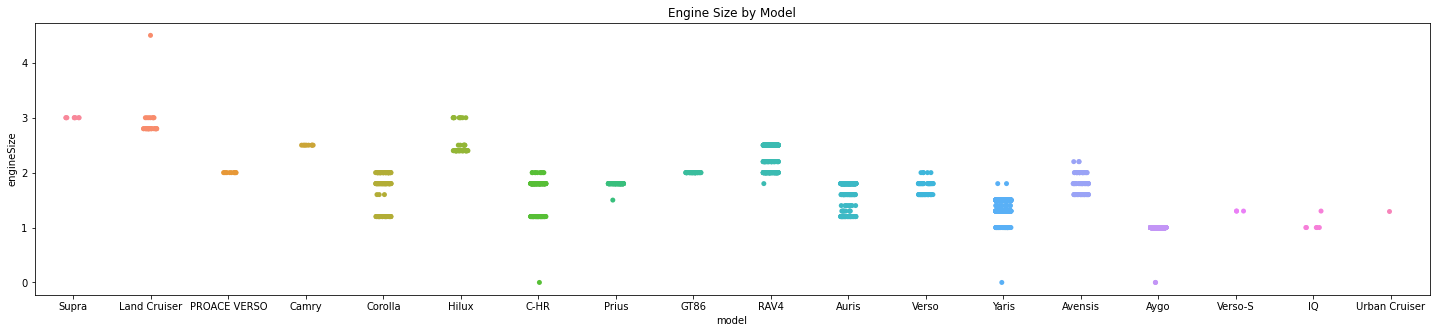

In [17]:
plt.figure(figsize=(25,5))
sns.stripplot(x='model',y='engineSize',order=table['model'].to_list(),data=df_train)
plt.title('Engine Size by Model')
plt.show()

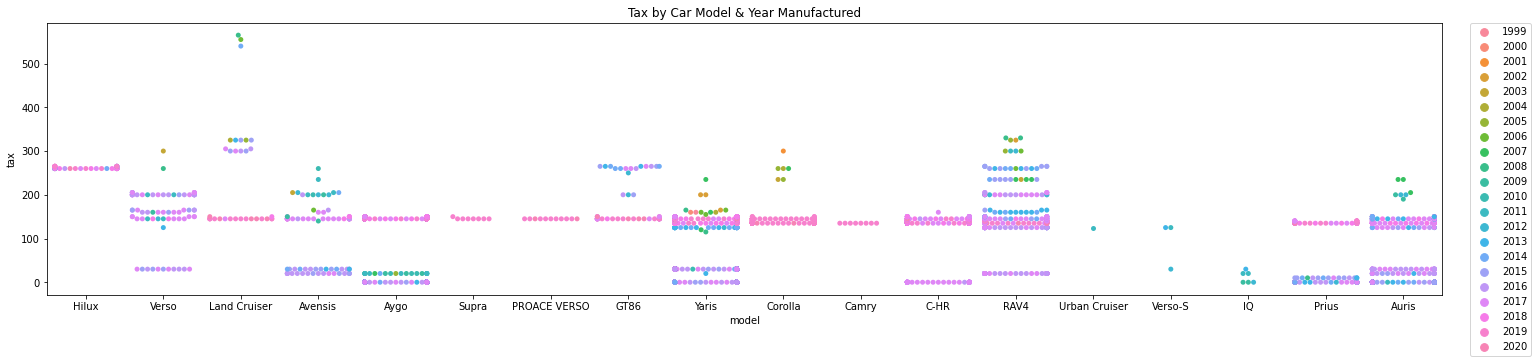

In [18]:
table = df_train.groupby(['model'],as_index=False)['tax'].median().sort_values(by='tax',ascending=False)

plt.figure(figsize=(25,5))
sns.swarmplot(x='model',y='tax', data=df_train, order=table['model'], hue='year')
plt.title('Tax by Car Model & Year Manufactured')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

The ages of the cars affect the amount of taxes charged for each model.

# **4. Data Preprocessing**

## **4A. Missing Data**

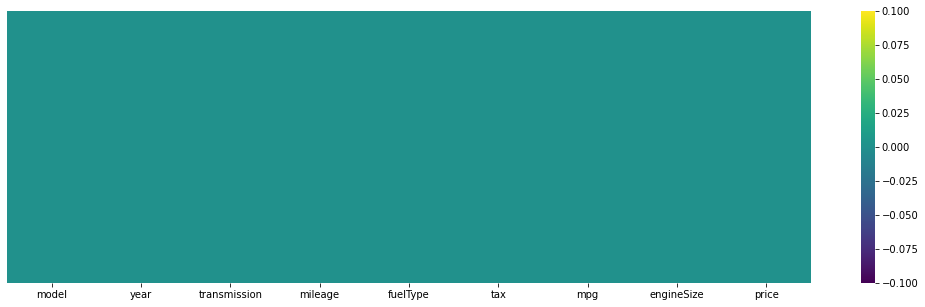

In [19]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df_train.isnull(), yticklabels=False,cmap='viridis')
plt.show()

No missing data could be seen in the train data.

## **4B. Encoding**

In [20]:
categorical_cols = ['model','transmission','fuelType']

X_train_cat = X_train[categorical_cols]
X_train_num = X_train.drop(categorical_cols,axis=1)
X_train_num = X_train_num.reset_index(drop=True)

#One Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat_enc = pd.DataFrame(encoder.fit_transform(X_train_cat))
X_train_cat_enc.columns = encoder.get_feature_names()

X_train_mix = pd.concat([X_train_num, X_train_cat_enc],axis=1)

#Scaling
scaler = StandardScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train_mix))
X_train_pre.columns = X_train_mix.columns


# **5. Modelling**

In [21]:
def regression(model):
    reg = model
    reg.fit(X_train_pre, y_train)
    score = cross_val_score(reg, X_train_pre, y_train, cv=5, scoring='r2').mean()
    return reg, score

In [22]:
models = {'LinearRegression':LinearRegression(), 'Ridge':Ridge(),
           'Lasso':Lasso(), 'RandomForestRegressor':RandomForestRegressor(), 
           'CatBoostRegressor':CatBoostRegressor(),
           'DecisionTreeRegressor':DecisionTreeRegressor()}

In [23]:
evaluation_table = pd.DataFrame(columns=['Model', 'R2 Score'])

models = {'LinearRegression':LinearRegression(), 'Ridge':Ridge(),
           'Lasso':Lasso(), 'RandomForestRegressor':RandomForestRegressor(), 
           'CatBoostRegressor':CatBoostRegressor(silent=True),
           'DecisionTreeRegressor':DecisionTreeRegressor()}

for name,model in models.items():
    reg, score = regression(model)
    evaluation_table = evaluation_table.append({'Model': name, 'R2 Score': score},
                                               ignore_index=True)

evaluation_table

Model      R2 Score
0       LinearRegression -6.844702e+19
1                  Ridge  9.230094e-01
2                  Lasso  9.230144e-01
3  RandomForestRegressor  9.578495e-01
4      CatBoostRegressor  9.645460e-01
5  DecisionTreeRegressor  9.347559e-01

Catboost produce the best outcomes. Let's use this regressor to predict the used-car price.

In [24]:
cat = CatBoostRegressor(silent=True)
cat.fit(X_train_pre, y_train)

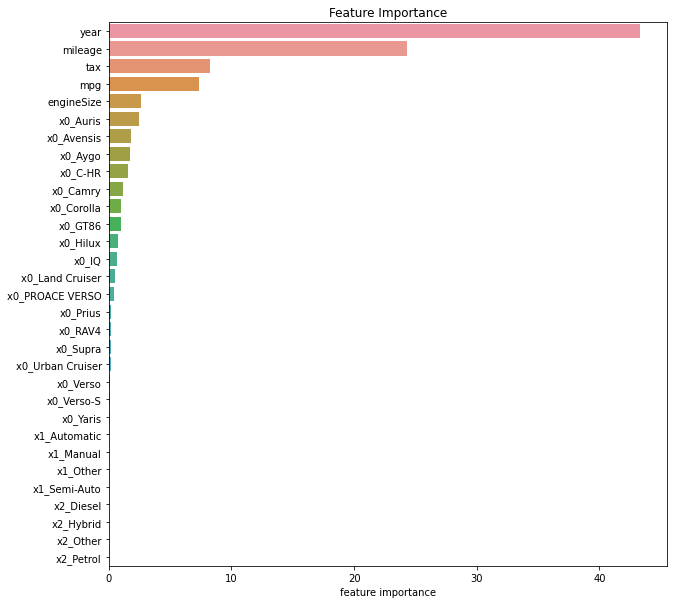

In [25]:
feature_imp = pd.DataFrame(cat.get_feature_importance()).sort_values(by=0,ascending=False)
feature_imp.index = X_train_pre.columns
feature_imp.columns = ['feature importance']

plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp['feature importance'], y=feature_imp.index)
plt.title('Feature Importance')
plt.show()

Year is by far the most important predictor of the price. Besides, mileage rank in the second which might be caused by its correlation with year.

In [26]:
X_test_cat = X_test[categorical_cols]
X_test_num = X_test.drop(categorical_cols, axis=1)
X_test_num = X_test_num.reset_index(drop=True)

#OneHot Encoding
X_test_cat_enc = pd.DataFrame(encoder.transform(X_test_cat))
X_test_cat_enc.columns = encoder.get_feature_names()

X_test_mix = pd.concat([X_test_num, X_test_cat_enc],axis=1)

#Scaling
X_test_pre = pd.DataFrame(scaler.transform(X_test_mix))
X_test_pre.columns = X_test_mix.columns

In [27]:
y_pred = cat.predict(X_test_pre)

print('R2 Score on Test Set:',r2_score(y_test,y_pred))

R2 Score on Test Set: 0.9734073606502714


The CatboostRegressor generate **97% R2 score** on the test set